{'dead_store': 70, 'control_flow': 12, 'case_not_terminated': 3, 'uninitialized_value': 10, 'cast_to_pointer': 5, 'memory_leak': 68}
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
found a match
trues is  {frozendict.frozendict({'input_file': '35ae2e259e4.c', 'line_number': 17, 'classification': frozenset({'TRUE', 'UNDER'}), 'type': 'memory_leak'

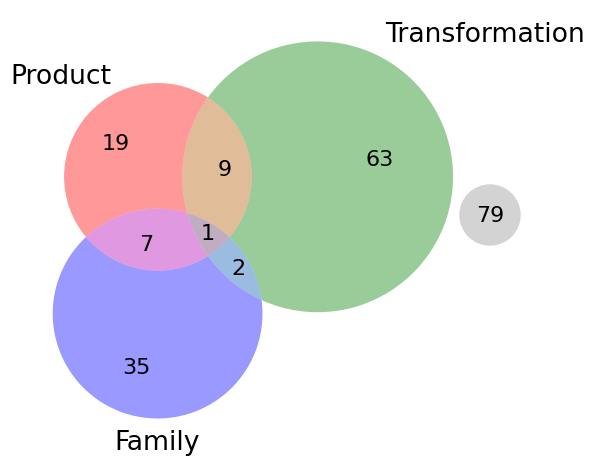

In [21]:
from fontTools.ttLib.woff2 import bboxFormat
from matplotlib.patches import Circle
from typing import Dict

import matplotlib.pyplot
import matplotlib.pyplot as plt
from frozendict import frozendict
import csv
import json
import re

from matplotlib_venn import venn3

family_location = "../results/current/family/varbugs_family.json"
product_location = "../results/current/product/varbugs_product.json"
transformation_location = "../results/current/transformation/varbugs_transformation.json"
csv_location = "../notes/classifications.csv"

# Read in results
with open(family_location) as family_file:
    family = json.load(family_file)
    for f in family:
        f['origin'] = 'family'
with open(product_location) as product_file:
    product = json.load(product_file)
    for p in product:
        p['origin'] = 'product'
with open(transformation_location) as transformation_file:
    transformation = json.load(transformation_file)
    for t in transformation:
        t['origin'] = 'transformation'
with open(csv_location) as csv_file:
    csv_reader = csv.DictReader(csv_file)
    rows = list(csv_reader)

all_results = family + product + transformation
for row in rows:
    for r in all_results:
        if r['id'] == row['ID']:
            r['classification'] = frozenset(row['Final Classification'].split("_"))
all_results

# Quick Stats
tp = len([a for a in all_results if 'TRUE' in a['classification']])
tp_new = len(all_new := [a for a in all_results if 'TRUE' in a['classification'] and 'NEW' in a['classification']])
fp = len([a for a in all_results if 'FALSE' in a['classification']])

new_types = dict()
for a in all_new:
    if a['taxonomy_type'] not in new_types:
        new_types[a['taxonomy_type']] = 1
    new_types[a['taxonomy_type']] += 1

print(new_types)

# Extract bug information
family_summaries = set()
for f in family:
    family_summaries.add(frozendict({
        "input_file": f["input_file"].split("/")[-1],
        "type": f["taxonomy_type"],
        "classification": f['classification'],
        "line_number": int(re.findall(r":(\d+):\d+", f["err"])[0]),
        "origin": frozenset({"family"})
    }))

product_summaries = set()
for p in product:
    product_summaries.add(frozendict({
        "input_file": p["input_file"].split("/")[-1],
        "line_number": int(p["input_line"]),
        "classification": p["classification"],
        "type": p["taxonomy_type"],
        "origin": frozenset({"product"})
    }))

def transform_linum(linum):
    if "ERROR" in linum:
        transform_linum.counter = transform_linum.counter - 1
        return transform_linum.counter
    else:
        return int(linum.split(":")[0])
transform_linum.counter = 0

transformation_summaries = set()
for t in transformation:
    transformation_summaries.add(frozendict({
        "input_file": t["input_file"].split("/")[-1].replace(".desugared", ""),
        "line_number": transform_linum(t["original_line"]),
        "classification": t["classification"],
        "type": t["taxonomy_type"],
        "origin": frozenset({"transformation"})
    }))

unique_summaries = set()
all_summaries = transformation_summaries.union(product_summaries).union(family_summaries)
for a in all_summaries:
    filter = {u for u in unique_summaries if u.get("input_file") == a.get("input_file") and u.get("classification") == a.get("classification") and u.get("line_number") == a.get("line_number") and u.get("type") == a.get("type")}
    if len(filter) == 0:
        unique_summaries.add(a)
    if len(filter) == 1:
        print("found a match")
        old = filter.pop()
        unique_summaries.remove(old)
        old.set("origin", old.get("origin").union(a.get("origin")))
        unique_summaries.add(old)
    if len(filter) == 2:
        raise RuntimeError("Too many matches")

def copy_without_origin(d: Dict) -> Dict:
  return frozendict({x: d[x] for x in d if x not in ["origin", "classification"]})

trues = set([u for u in unique_summaries if "TRUE" in u.get("classification")])
trues_only_extant = set([t for t in trues if "NEW" not in t.get("classification")])
print("trues is ", trues_only_extant)

# Open csv that has the list of all bugs, and compare to see which ones were not found
with open("vbdb_bugs.csv") as csv_file:
    csv_reader = csv.DictReader(csv_file)
    rows = list(csv_reader)

fns = []
all_files_with_true = {t.get("input_file").split(".")[0] for t in trues_only_extant}
for r in rows:
    if r['commit'] not in all_files_with_true:
        fns.append(r)

with open("false_negatives.json", "w") as out_file:
  json.dump(fns, out_file, indent=2)
        
print("Number of true results is " + str(len({copy_without_origin(t) for t in trues})))
matplotlib.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-4, 6)    # adjust right limit so x + radius fits
ax.set_ylim(-4, 4)
ax.axis('off')
venn = venn3((
    product_set := {copy_without_origin(u) for u in trues if "product" in u.get("origin")},
    transformation_set := {copy_without_origin(u) for u in trues if "transformation" in u.get("origin")},
    family_set := {copy_without_origin(u) for u in trues if "family" in u.get("origin")}
),
set_labels=("Product", "Transformation", "Family"), ax=ax)

# Sanity check
diff = {copy_without_origin(t) for t in trues}.difference(product_set.union(transformation_set).union(family_set))
# Draw the gray circle OUTSIDE the Axes bounds using Figure coordinates
# (0, 0) is bottom-left of the figure, (1, 1) is top-right
x_inches, y_inches =4.9, 2.5  # Move this as needed to place right of your plot
radius_inches = 0.3

# Convert inches to pixels (DPI) and use `dpi_scale_trans`
transform = fig.dpi_scale_trans
circle = Circle((x_inches, y_inches), radius_inches, transform=transform, color='lightgray', zorder=3)
fig.patches.append(circle)

# Text near the circle, in the same transform
fig.text(x_inches, y_inches, '79',
         transform=transform,
         ha='center', va='center', fontsize=16, zorder=4)# Correct save

fig.savefig("/Users/austin/git/sugarlyzer-paper/resources/vbdb_tps.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
import os
from taxonomy import WarningTypes

VBDB_REPO_LOCATION = "../resources/programs/varbugs/vbdb"

# Gather all bug types
def get_varbugs_types():
    for root, _, files in os.walk(f"{VBDB_REPO_LOCATION}"):
        for f in [fi for fi in files if fi.endswith(".bug")]:
            with open(f"{root}/{f}", "r") as in_file:
                yield f.split(".")[0], [l for l in in_file.readlines() if l.startswith("type:")][0].split(":")[1].strip()

def map_warning_type(typ):
    if typ == "DeadCode" or typ == "UndefinedSymbol":
        return WarningTypes.DEAD_STORE
    if typ == "MemoryLeak":
        return WarningTypes.MEMORY_LEAK
    if typ == "UndeclaredIdentifier":
        return WarningTypes.UNDECLARED_IDENTIFIER
    if typ == "UninitializedVariable":
        return WarningTypes.UNINITIALIZED_VALUE
    else:
        return "bottom"

ground_truth = [{"file": fi, "type": map_warning_type(typ)} for fi, typ in get_varbugs_types()]
print(ground_truth)

[{'file': 'b8e79dc', 'type': <WarningTypes.UNDECLARED_IDENTIFIER: 'undeclared_identifier'>}, {'file': 'fdac8f6', 'type': <WarningTypes.UNDECLARED_IDENTIFIER: 'undeclared_identifier'>}, {'file': '2db384a', 'type': 'bottom'}, {'file': '7336e6d', 'type': <WarningTypes.UNDECLARED_IDENTIFIER: 'undeclared_identifier'>}, {'file': 'e30bfed', 'type': <WarningTypes.UNDECLARED_IDENTIFIER: 'undeclared_identifier'>}, {'file': '831016b', 'type': 'bottom'}, {'file': '2d22902', 'type': 'bottom'}, {'file': '31873ec', 'type': 'bottom'}, {'file': '3024821', 'type': 'bottom'}, {'file': 'f87c808', 'type': 'bottom'}, {'file': '53be0f3', 'type': 'bottom'}, {'file': 'a7fc1f8', 'type': 'bottom'}, {'file': 'fc3c76f', 'type': 'bottom'}, {'file': '8c4377d', 'type': 'bottom'}, {'file': 'cf1f2ac', 'type': <WarningTypes.DEAD_STORE: 'dead_store'>}, {'file': '1b487ea', 'type': 'bottom'}, {'file': 'b62bd7b', 'type': 'bottom'}, {'file': '199501f', 'type': 'bottom'}, {'file': 'df7b657', 'type': 'bottom'}, {'file': '5cd64

In [7]:
print(f"Number of unique summaries: {len(unique_summaries)}")
new_tp = [a for a in unique_summaries if "TRUE" in a['classification'] and "NEW" in a['classification']]
old_tp = [a for a in unique_summaries if "TRUE" in a['classification'] and "NEW" not in a['classification']]
total_fp = [a for a in unique_summaries if "FALSE" in a['classification']]
print(f"Total classifications: {len(unique_summaries)}")
print(f"New tp: {len(new_tp)}")
print(f"Old tp: {len(old_tp)}")
print(f"Total fp: {len(total_fp)}")
print(f"Length of ground truth: {len(ground_truth)}")
print(f"FN: {len(ground_truth) - len(old_tp)}")
all_tp = len(ground_truth) + len(new_tp)
print(f"Total tp: {all_tp}")

def get_all_types_from_approach(approach_res):
    return {s['type'] for s in approach_res}

# Individual Precision and Recall
for origin, s in [('product', product_set), ('family', family_set), ('transformation', transformation_set)]:
    tp = s
    fp = {copy_without_origin(u) for u in unique_summaries if origin in u.get("origin") and "FALSE" in u.get("classification")}
    precision = len(tp) / (len(tp) + len(fp))
    recall = len(tp) / all_tp
    all_types = get_all_types_from_approach(tp.union(fp))
    discoverable_ntp = [n for n in new_tp if n['type'] in all_types]
    discoverable_tp = [g for g in ground_truth if g['type'] in all_types]
    true_recall = len(tp) / (len(discoverable_ntp) + len(discoverable_tp))
    print(f"FP of {origin}: {len(fp)}")
    print(f"Precision of {origin}: {len(tp)} / {len(tp) + len(fp)} = {precision}")
    print(f"Recall of {origin}: {len(tp)} / {all_tp} = {recall}")
    print(f"False positives of {origin}: {len(fp)}")
    print(f"True recall of {origin}: {true_recall}")
    print(f"Discoverable TP of {origin}: {len(discoverable_tp) + len(discoverable_ntp)}")
    print(f"Non-discoverable New TP of {origin}: {all_tp - len(discoverable_ntp) - len(discoverable_tp)}")

Number of unique summaries: 263
Total classifications: 263
New tp: 117
Old tp: 45
Total fp: 100
Length of ground truth: 98
FN: 53
Total tp: 215
FP of product: 9
Precision of product: 36 / 45 = 0.8
Recall of product: 36 / 215 = 0.16744186046511628
False positives of product: 9
True recall of product: 0.32432432432432434
Discoverable TP of product: 111
Non-discoverable New TP of product: 104
FP of family: 18
Precision of family: 45 / 63 = 0.7142857142857143
Recall of family: 45 / 215 = 0.20930232558139536
False positives of family: 18
True recall of family: 0.5113636363636364
Discoverable TP of family: 88
Non-discoverable New TP of family: 127
FP of transformation: 73
Precision of transformation: 75 / 148 = 0.5067567567567568
Recall of transformation: 75 / 215 = 0.3488372093023256
False positives of transformation: 73
True recall of transformation: 0.5952380952380952
Discoverable TP of transformation: 126
Non-discoverable New TP of transformation: 89
